In [1]:
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import os
import json

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from scipy import stats

from models.linear_regressions import Linear_reg
from scripts.frame_methods import scale_df, one_hot_dataframe

load_dotenv()
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100

warnings.filterwarnings("ignore")


<i>micro note : I use hashes freely for titles or important cells in mkdown, even though it sometimes doesnt change the layout, it eases access using Outline from Vscode</i>

# Feature engineering :

On cherche avant tout a maximiser l'efficacité du modèle en ajustant les données.On utilisera cela comme baseline `standard_scaler` de `sklearn` pour les benchmarks
<br>
Certaines features peuvent eventuellement être retouchées pour augmenter la precision de la modelisation. <br>

- On peut analyser la repartition et la deviation des variables lineaires continues. Selon ces parametres, on appliquera un Standard Scaler, un passage au log, a la racine carrée ou en utilisant la methode de Box Cox
- Les données concernant la taille des batiments (taille totale, taille batiments, taille parkings) peut etre simplifiee : on peut utiliser la proportion de batiments et de parkings pour eviter les repetitions.
- Les features categorielles non ordinales doivent etre encodée (sauf utilisation de CatBoost, hors de cette etude), on utilisera One Hot Encoder.
- Conversion de "Year Built" vers "Building Age", cela devrait reduire le poids de cette variable qui ne semblait pas avoir beaucoup d'influence sur les emissions de GES ou la consommation electrique durant l'analyse.
- Ajout d'une nouvelle metrique booleene : Energy_Star_Certified (E* >= 75). Cela peut etre une alternative a l'elimination totale de cette variable au profit d'un calcul plus simple. L'etude de classification de cette feature est hors du spectre de l'etude mais pourrait fournir une piste pour obtenir plus facilement les données E* sans les calculer.
<br>
<hr>
<br>


- ## 1 - Modification des variables : Building Age, Proportions (parking / building), Certification E*
- ## 2 - Analyse detaillée de la deviation et de la repartition des variables lineaires continues, application de la methode optimale
    - _note : on sauvegarde un dataset standardisé pour comparaisons_ <br><br>
- ## 3 - Application de One Hot Encoder sur PrimaryPropertyType et Neighborhood, creation des nouveaux dataframes
    - On s'attend à un très grand nombre de de nouvelles colonnes, on applique donc cette modification en dernier <br><br>
- ## 4 - Benchmark
    - On compare les metriques de la regression du nouveau dataset avec celles de base (std_scaled)
        - Si les metriques sont meilleure : On change de dataset
        - Sinon : on utilise le dataset sauvegardé dans 2 _note_

In [2]:
raw_dataset = "./data/seattle_raw_data.csv"


In [3]:
df_raw = pd.read_csv(raw_dataset)
df_raw.set_index("OSEBuildingID", inplace=True)


In [4]:
df_raw.columns


Index(['PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Electricity(kWh)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'PropertyArea(SquareMetre)Total',
       'PropertyArea(SquareMetre)Parking',
       'PropertyArea(SquareMetre)Building(s)',
       'LargestPropertyUseTypeArea(SquareMetre)', 'SourceEUI(kWh/m2)',
       'NaturalGas(kWh)'],
      dtype='object')

In [5]:
df_raw.head()


,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Electricity(kWh),GHGEmissionsIntensity(kgCO2e/ft2),PropertyArea(SquareMetre)Total,PropertyArea(SquareMetre)Parking,PropertyArea(SquareMetre)Building(s),LargestPropertyUseTypeArea(SquareMetre),SourceEUI(kWh/m2),NaturalGas(kWh)
OSEBuildingID,,,,,,,,,,,,,,
1,Hotel,DOWNTOWN,1927,1,12,60.0,1.156466e+06,2.83,8215.787439,0.000000,8215.787439,8215.787439,575.712675,3.740915e+05
2,Hotel,DOWNTOWN,1996,1,11,61.0,9.503859e+05,2.86,9621.596241,1399.491395,8222.104846,7792.706995,555.523318,1.507875e+06
5,Hotel,DOWNTOWN,1926,1,10,56.0,8.114916e+05,4.67,5696.814413,0.000000,5696.814413,5696.814413,682.022348,5.308142e+05
10,Hotel,DOWNTOWN,1926,1,11,27.0,8.238859e+05,2.12,7711.695544,0.000000,7711.695544,7557.848110,462.462913,8.638505e+05
17,Hotel,DOWNTOWN,1928,1,9,48.0,3.935945e+05,5.05,6039.533727,0.000000,6039.533727,6039.533727,484.545043,1.054090e+06


In [6]:
df_raw["Neighborhood"] = df_raw["Neighborhood"].apply(str.upper)
# It will make sense when we apply OHE and save a lot of repetitions


### 1 : Modifications des variables :

- Age
- Proportion de batiments/parking
- Certifié E* (boolean)


#### 1.1 : Age des batiments

In [7]:
df_raw["BuildingAge"] = np.nan
for index, row in df_raw.iterrows():
    df_raw.loc[index, "BuildingAge"] = int(2022 - row["YearBuilt"])

df_raw.drop(columns=["YearBuilt"], inplace=True)


In [8]:
# Check

df_raw["BuildingAge"].head()

# cf. cell 5 (previous call of .head() method), comparison checks up


OSEBuildingID
1     95.0
2     26.0
5     96.0
10    96.0
17    94.0
Name: BuildingAge, dtype: float64

#### 1.2 : Ajout d'une nouvelle variable : Energy Star Certified

In [9]:
df_raw["EnergyStarCert"] = 0
for index, row in df_raw.iterrows():
    if row["ENERGYSTARScore"] >= 75:
        df_raw.loc[index, "EnergyStarCert"] = 1


In [10]:
# Check :

df_raw[["EnergyStarCert", "ENERGYSTARScore"]].head(n=10)

# Coherent (0 if < 75, 1 if >= 75) , moving on


,EnergyStarCert,ENERGYSTARScore
OSEBuildingID,,
1,0,60.0
2,0,61.0
5,0,56.0
10,0,27.0
17,0,48.0
28,1,95.0
29,1,84.0
35,0,57.0
36,1,75.0


#### 1.3 : Modifications de variables : Proportion de parkings/batiments
- Il est inutile de fournir la surface dediee a chaque activité au modele : `surface = proportion_Building*taille_totale + proportion_Parking*taille_totale`
- L'utilisation d'un arrondi a 3 decimales causera dans certains cas `building_prop + parking_prop =/= 1`

In [11]:
df_raw["Parking_proportion"] = np.nan
df_raw["Building_proportion"] = np.nan

for index, series in df_raw.iterrows():
    parking_prop = np.round(series["PropertyArea(SquareMetre)Parking"] / series["PropertyArea(SquareMetre)Total"], decimals=3)
    building_prop = np.round(series["PropertyArea(SquareMetre)Building(s)"] / series["PropertyArea(SquareMetre)Total"], decimals=3)
    df_raw.loc[index, "Parking_proportion"] = parking_prop
    df_raw.loc[index, "Building_proportion"] = building_prop

redundancies = ["LargestPropertyUseTypeArea(SquareMetre)", "PropertyArea(SquareMetre)Parking", "PropertyArea(SquareMetre)Building(s)"]

df_raw = df_raw.drop(columns=redundancies, errors="ignore")


In [12]:
# Check : (if propP+propB =/= 1 : oops)

df_raw[["Parking_proportion", "Building_proportion"]].head()


,Parking_proportion,Building_proportion
OSEBuildingID,,
1,0.000,1.000
2,0.145,0.855
5,0.000,1.000
10,0.000,1.000
17,0.000,1.000


### 2 - Analyse detaillée de la deviation et de la repartition des variables lineaires continues, application de la methode optimale

#### 2.0 Standardisation et mise à l'echelle pour comparaison :

In [13]:
## Scaling : 
## Doubling targets : Scaled if in X_matrix, but not as target

df_raw["target_GHGEmissionsIntensity(kgCO2e/ft2)"] = df_raw["GHGEmissionsIntensity(kgCO2e/ft2)"]
df_raw["target_SourceEUI(kWh/m2)"] = df_raw["SourceEUI(kWh/m2)"]


exempt_mod_cols = [
    "PrimaryPropertyType", "Neighborhood", "BuildingAge", "NumberofBuildings", "NumberofFloors",
    "ENERGYSTARScore", "Building_proportion", "Parking_proportion", "EnergyStarCert",
    "target_SourceEUI(kWh/m2)", "target_GHGEmissionsIntensity(kgCO2e/ft2)"  # Ignore targets
    ]

df_std_scaled = scale_df(df_raw, constant_col=exempt_mod_cols)


In [14]:
# Check : 

df_std_scaled.head(n=2)


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),PrimaryPropertyType,Neighborhood,BuildingAge,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,Parking_proportion,EnergyStarCert,target_SourceEUI(kWh/m2),target_GHGEmissionsIntensity(kgCO2e/ft2)
OSEBuildingID,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,Hotel,DOWNTOWN,95.0,1,12,60.0,1.000,0.000,0,575.712675,2.83
2,0.615322,1.799564,0.659821,0.913481,4.178122,Hotel,DOWNTOWN,26.0,1,11,61.0,0.855,0.145,0,555.523318,2.86


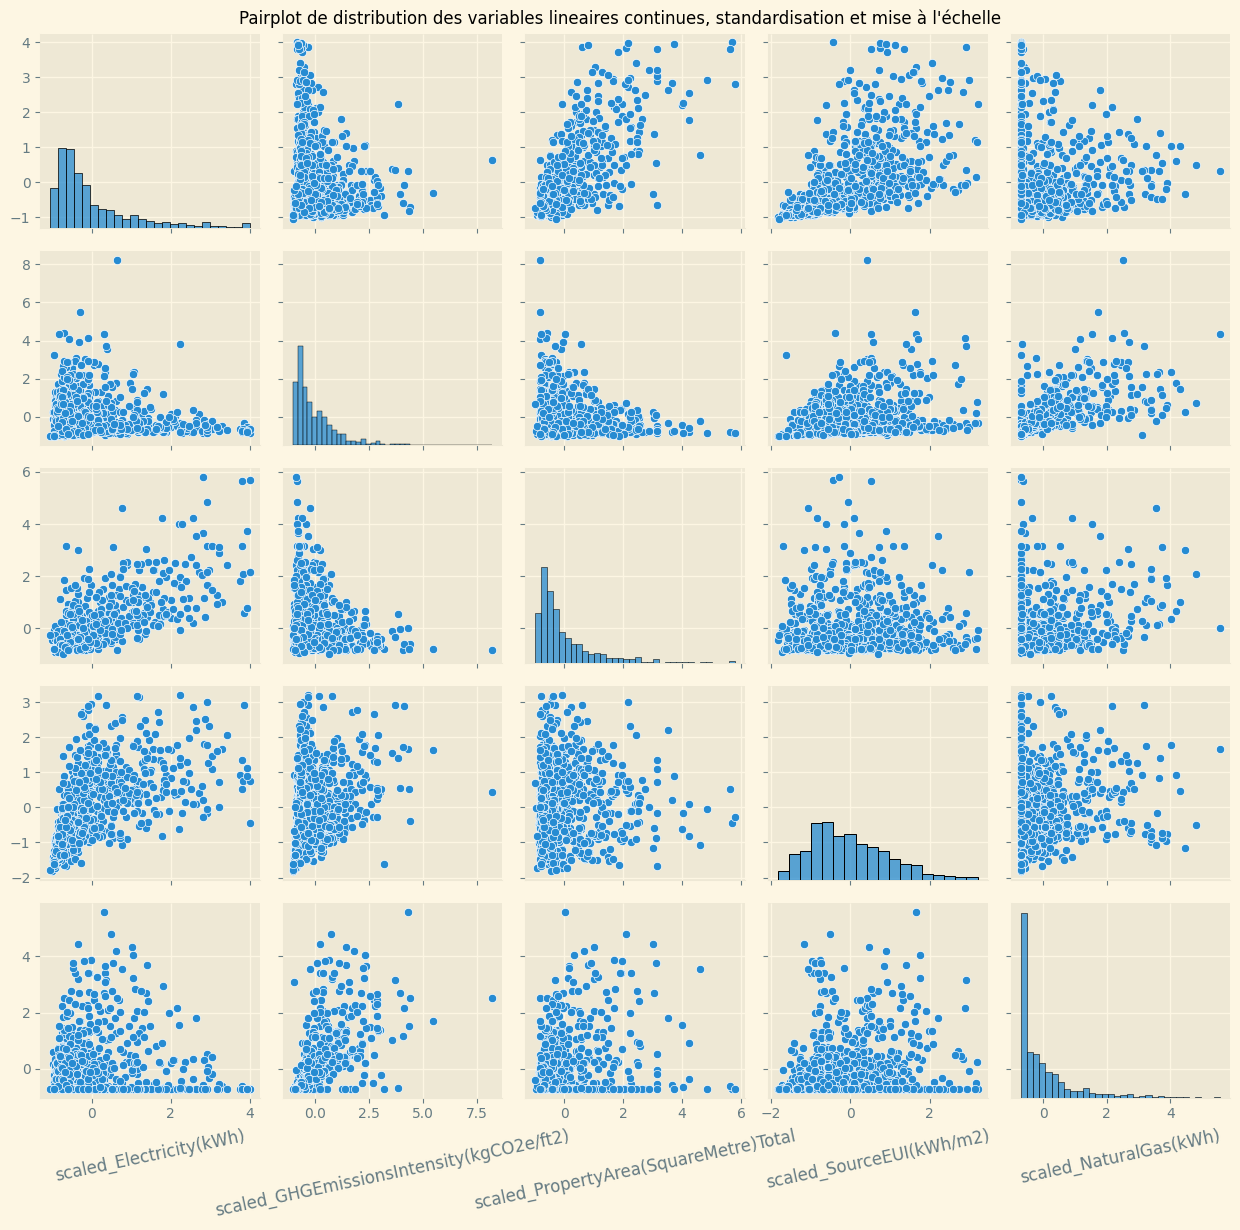

In [15]:
col_subset_std = [
    "scaled_Electricity(kWh)", "scaled_GHGEmissionsIntensity(kgCO2e/ft2)", 
    "scaled_PropertyArea(SquareMetre)Total", "scaled_SourceEUI(kWh/m2)", 
    "scaled_NaturalGas(kWh)"
    ]

pairplot = sns.pairplot(
    data=df_std_scaled[col_subset_std]
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("""Pairplot de distribution des variables\
 lineaires continues, standardisation et mise à l'échelle""")
#
###

plt.tight_layout()
plt.show()


##### Observations :

- Source_EUI, PropertyArea, semblent être relativement normalement réparties
- On enregistre la deviation des variables pour future comparaison


In [16]:
skew_std_scaled = dict.fromkeys(col_subset_std)
for col in skew_std_scaled.keys():
    skew_std_scaled[col] = df_std_scaled[col].skew()


##### Copies and columns to study
- Making copies (not with df1 = df2 to avoid codependencies issues)

#### 2.1 : Passage au log

In [17]:
df_log = df_raw.copy(deep=True)
df_sqrt = df_raw.copy(deep=True)
df_bcx = df_raw.copy(deep=True)

col_subset = [
    "Electricity(kWh)", "GHGEmissionsIntensity(kgCO2e/ft2)", 
    "PropertyArea(SquareMetre)Total", "SourceEUI(kWh/m2)", "NaturalGas(kWh)"
    ]


In [18]:
# check 1 : 

for col in col_subset:
    print((df_log[col] == 0).sum(), col)


1 Electricity(kWh)
1 GHGEmissionsIntensity(kgCO2e/ft2)
0 PropertyArea(SquareMetre)Total
1 SourceEUI(kWh/m2)
271 NaturalGas(kWh)


In [19]:
# just add 1 to all zeroes in log_data since log(1) = 0: 

for col in col_subset:
    df_log[col].replace(to_replace=0, value=1, inplace=True)


In [20]:
# check 2 : 

for col in col_subset:
    print((df_log[col] == 0).sum(), col)



0 Electricity(kWh)
0 GHGEmissionsIntensity(kgCO2e/ft2)
0 PropertyArea(SquareMetre)Total
0 SourceEUI(kWh/m2)
0 NaturalGas(kWh)


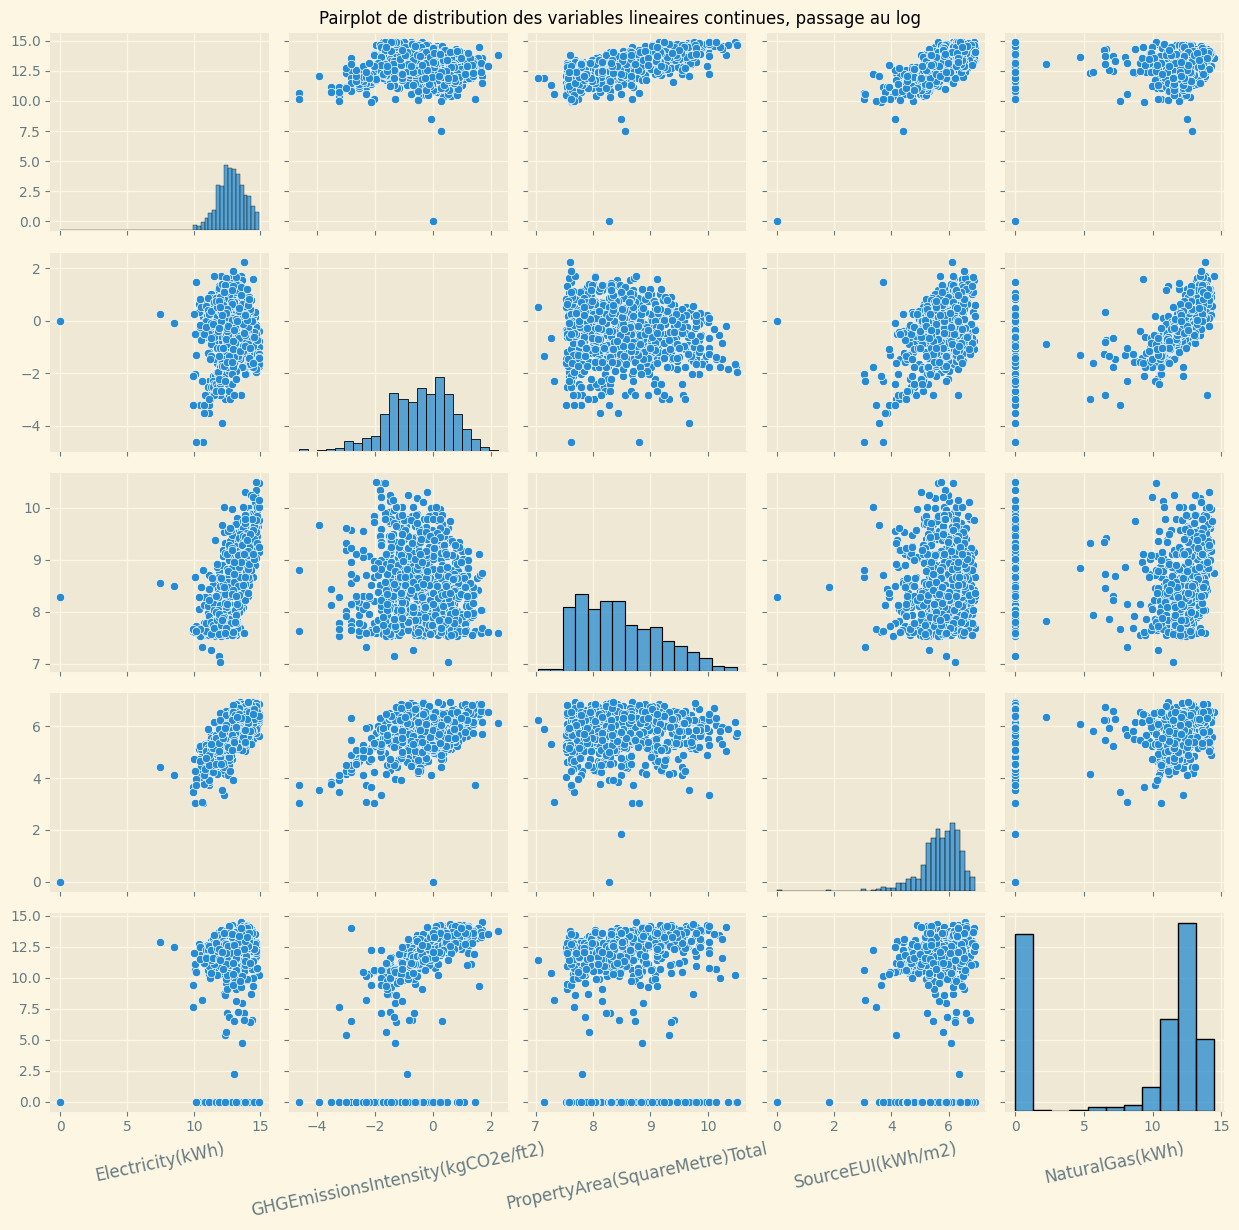

In [21]:
log_data = df_log[col_subset]

for column in log_data.columns:
    log_data[column] = np.log(log_data[column])

pairplot = sns.pairplot(
    data=log_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage au log")
#
###

plt.tight_layout()
plt.show()


##### Observations : 
- Il est compliqué d'évaluer l'effet sur la deviation à l'oeil nu : enregistrement pour comparaison
- Check necessaire : df_raw ne contient pas de valeurs NaN, si des NaNs se manifestent, la cause est que la valeur est egale a 0
    - log(0) = -inf

In [22]:
# checks : 

log_data.isna().sum()

# Seems we have a winner, might be a park or something that doesnt use energy / doesnt emmit GHG, will fill with 0


Electricity(kWh)                     1
GHGEmissionsIntensity(kgCO2e/ft2)    1
PropertyArea(SquareMetre)Total       0
SourceEUI(kWh/m2)                    0
NaturalGas(kWh)                      0
dtype: int64

In [23]:
skew_logged = dict.fromkeys(col_subset)
for col in skew_logged.keys():
    skew_logged[col] = log_data[col].skew(skipna=True)

skew_logged


{'Electricity(kWh)': -1.9716940032992776,
 'GHGEmissionsIntensity(kgCO2e/ft2)': -0.44455137612699647,
 'PropertyArea(SquareMetre)Total': 0.5898718071984281,
 'SourceEUI(kWh/m2)': -1.5899774376996654,
 'NaturalGas(kWh)': -0.6948020684370033}

##### Remarque :

- Le micro-fix consistant a remplacer les 0 par des 1 a fonctionné correctement
- Enregistrement de la deviation pour comparaison


#### 2.2 : Passage à la racine carrée

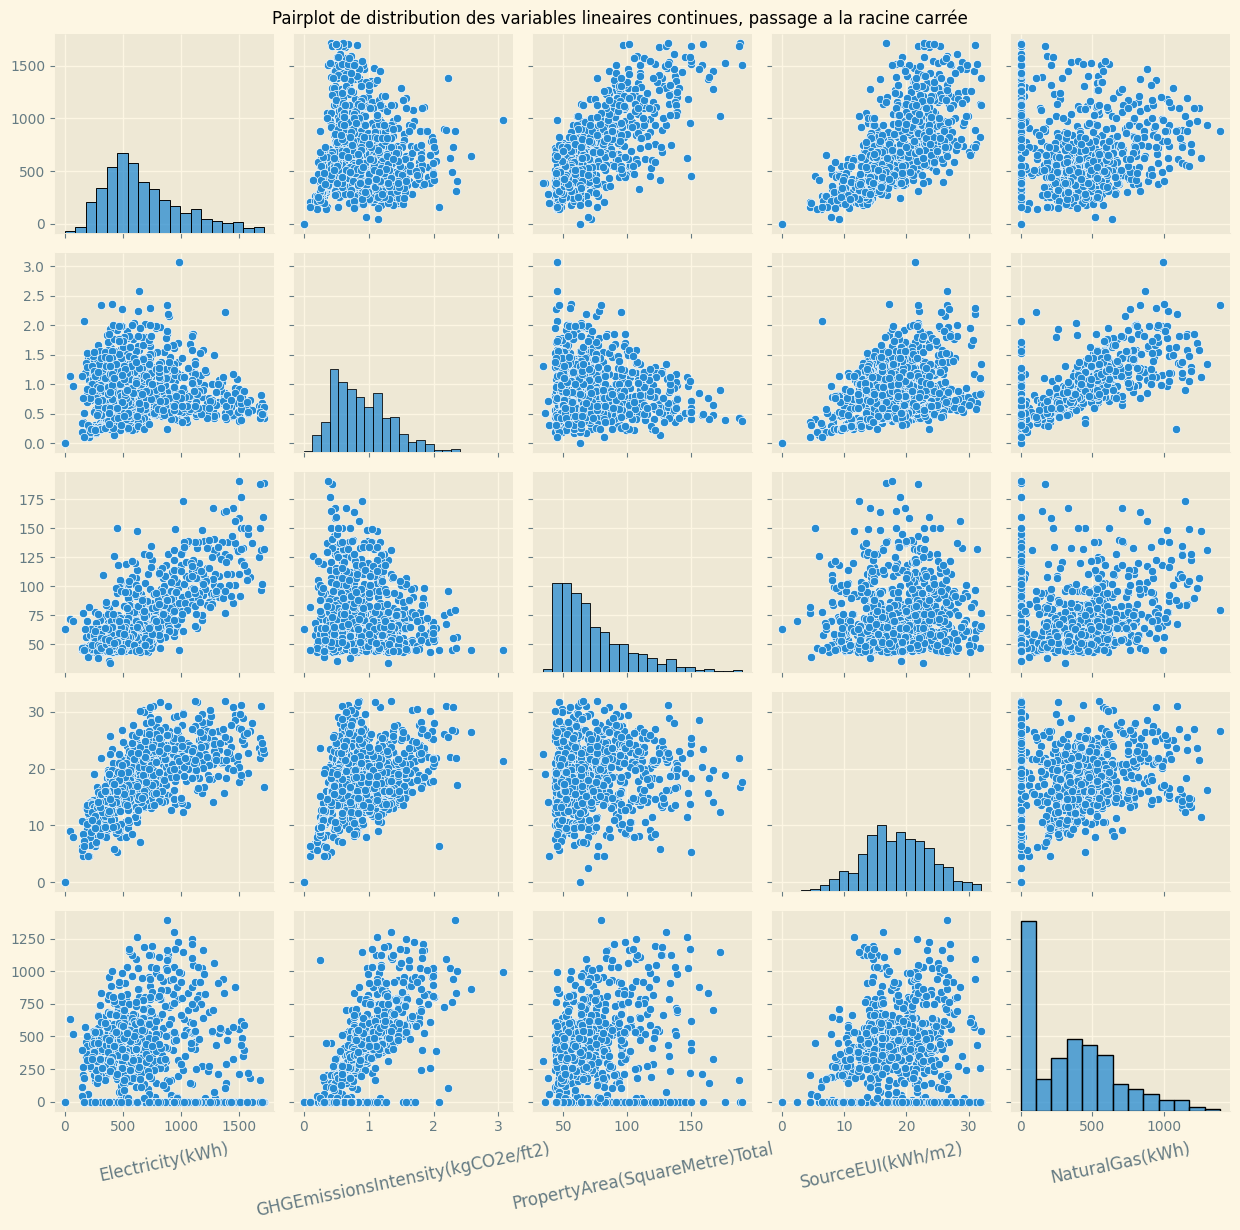

In [24]:
sqrt_data = df_sqrt[col_subset]

for column in sqrt_data.columns:
    sqrt_data[column] = np.sqrt(sqrt_data[column])

pairplot = sns.pairplot(
    data=sqrt_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, passage a la racine carrée")
#
###

plt.tight_layout()
plt.show()


##### Observations : Il semble encore une fois compliqué de conclure sur la distribution à l'oeil nu

- On s'attend à voir deux resultats NaN : cf. hypothèse plus haut, on forcera le passage a 0
- On enregistre les valeurs de deviation

In [25]:
skew_sqrt = dict.fromkeys(col_subset)
for col in skew_sqrt.keys():
    skew_sqrt[col] = sqrt_data[col].skew()

skew_sqrt


{'Electricity(kWh)': 0.8793089997087102,
 'GHGEmissionsIntensity(kgCO2e/ft2)': 0.8285128351742732,
 'PropertyArea(SquareMetre)Total': 1.303543329896967,
 'SourceEUI(kWh/m2)': -0.018985565524061002,
 'NaturalGas(kWh)': 0.6566275254300923}

In [26]:
# checks : 

sqrt_data.isna().sum()

# Called it ! Most likely the same one. Will perform same check before outputting to csv


Electricity(kWh)                     1
GHGEmissionsIntensity(kgCO2e/ft2)    1
PropertyArea(SquareMetre)Total       0
SourceEUI(kWh/m2)                    0
NaturalGas(kWh)                      0
dtype: int64

#### 2.3 : Utilisation de la methode de Box Cox

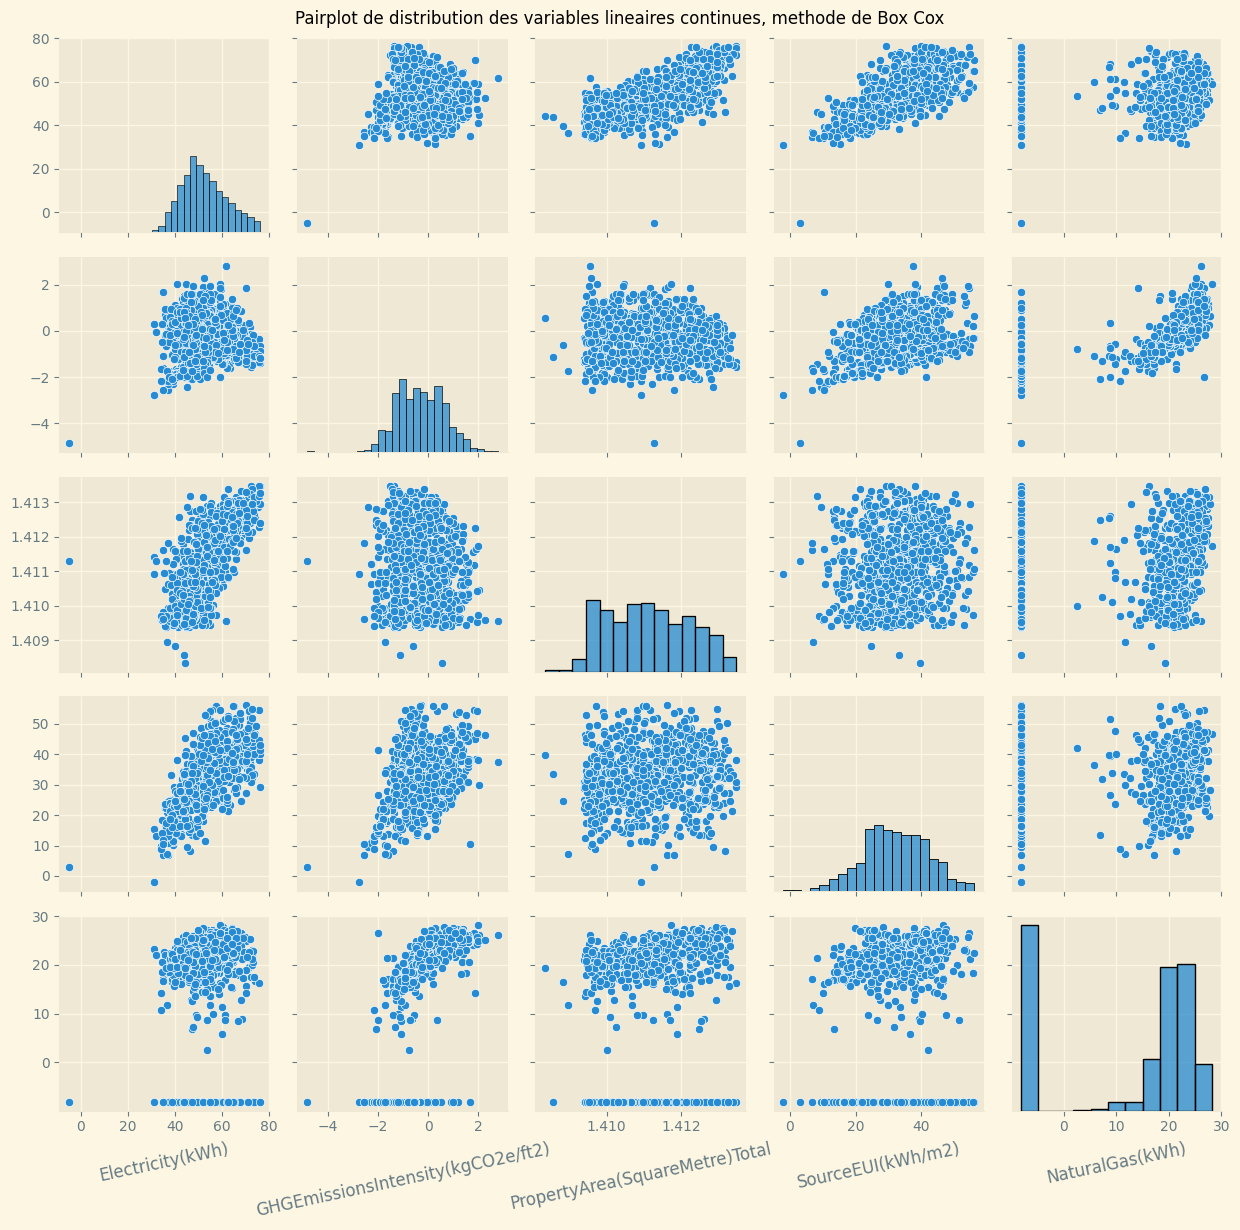

In [27]:
box_cox_data = df_bcx[col_subset]

for column in box_cox_data.columns:
    values = box_cox_data[column].values
    constant = abs(min(values)) + 0.000001
    new_values = values + constant
    new_values = stats.boxcox(new_values)
    box_cox_data[column] = new_values[0]

pairplot = sns.pairplot(
    data=box_cox_data
)

pairplot.figure.set_dpi(100)

###
# Titles/Lables
for axes in pairplot.axes.flat:
    axes.set_ylabel("")
    axes.set_xlabel(axes.get_xlabel(), rotation=12)
pairplot.figure.suptitle("Pairplot de distribution des variables lineaires continues, methode de Box Cox")
#
###

plt.tight_layout()
plt.show()


##### Observations : 
- Memes conclusions, on attend les chiffres pour proceder a une modification
- Reverification des valeurs NaNs (on devrait n'avoir aucun NaN du fait de l'ajout d'une constante --> `constant = abs(min(values)) + 0.000001`

In [28]:
skew_box_cox = dict.fromkeys(col_subset)
for col in skew_box_cox.keys():
    skew_box_cox[col] = box_cox_data[col].skew()


In [29]:
# Check : 

box_cox_data.isna().sum()

# Called it again


Electricity(kWh)                     0
GHGEmissionsIntensity(kgCO2e/ft2)    0
PropertyArea(SquareMetre)Total       0
SourceEUI(kWh/m2)                    0
NaturalGas(kWh)                      0
dtype: int64

In [58]:
names = [name[7:] for name in skew_std_scaled.keys()]  # Removed "scaled_"
results = pd.DataFrame(data=skew_std_scaled.values(), columns=["standard_scaled"], index=names)
results["log"] = skew_logged.values()
results["sqrt"] = skew_sqrt.values()
results["box_cox"] = skew_box_cox.values()
results = results.T  # Transformation as index


In [59]:
results


,Electricity(kWh),GHGEmissionsIntensity(kgCO2e/ft2),PropertyArea(SquareMetre)Total,SourceEUI(kWh/m2),NaturalGas(kWh)
standard_scaled,1.784896,2.279158,2.231357,0.713349,2.154545
log,-1.971694,-0.444551,0.589872,-1.589977,-0.694802
sqrt,0.879309,0.828513,1.303543,-0.018986,0.656628
box_cox,0.140080,0.039486,0.140383,-0.054231,-0.678844


Utilisation de la valeur absolue minimale pour trouver la transformation adaptée à chaque variable :

In [32]:
print("\n##############\n")

for col in results.columns:
    temp = abs(results[col])
    print(f"Minimal skew with {temp.idxmin()} for col {col[7:]} : skew = {results[col][temp.idxmin()]}")

print("\n##############\n")

for col in results.columns:
    temp = abs(results[col].drop(index=["box_cox"]))
    print(f" Minimal skew (without BCx) with {temp.idxmin()} for col {col[7:]} : skew = {results[col][temp.idxmin()]}")

print("\n##############\n")



##############

Minimal skew with box_cox for col Electricity(kWh) : skew = 0.14008000636298587
Minimal skew with box_cox for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = 0.039485740356718965
Minimal skew with box_cox for col PropertyArea(SquareMetre)Total : skew = 0.1403831497723843
Minimal skew with sqrt for col SourceEUI(kWh/m2) : skew = -0.018985565524061002
Minimal skew with sqrt for col NaturalGas(kWh) : skew = 0.6566275254300923

##############

 Minimal skew (without BCx) with sqrt for col Electricity(kWh) : skew = 0.8793089997087102
 Minimal skew (without BCx) with log for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = -0.44455137612699647
 Minimal skew (without BCx) with log for col PropertyArea(SquareMetre)Total : skew = 0.5898718071984281
 Minimal skew (without BCx) with sqrt for col SourceEUI(kWh/m2) : skew = -0.018985565524061002
 Minimal skew (without BCx) with sqrt for col NaturalGas(kWh) : skew = 0.6566275254300923

##############



### 3 : Application de One Hot Encoder sur PrimaryPropertyType et Neighborhood

#### 3.1 : Application des transformations sur les variables lineaires continues :
- 1 : Baseline en utilisant seulement standard_scaler
- 2 : Deviation la plus faible (incluant la methode de Box Cox)
- 3 : Deviation la plus faible (exclusion de la methode de Box Cox)
 

##### 3.1.1 : Standard scaler + OHE

In [33]:
# df_std_scaled is already modified, lets just use OHE and we will be fine with that

ohe_subset = ["PrimaryPropertyType", "Neighborhood"]
ohe_prefix = ["Ptype", "Nbhood"]

df_std_scaled = one_hot_dataframe(
    dataframe=df_std_scaled,
    subset=ohe_subset,
    prefix=ohe_prefix,
    drop_og=True
    )


In [34]:
# Checking : 

df_std_scaled.columns

# ||| should be plenty of OHE and no PrimaryPropertyType & Neighbourhood (im bad at words)
# |V| candidate 1 is ready, now for number 2 : 


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'BuildingAge', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'EnergyStarCert', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_Ptype_Hospital',
       'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School', 'ohe_Ptype_Large Office',
       'ohe_Ptype_Mixed Use Property', 'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbh

##### 3.1.2 : Candidate_2 (w/ Box Cox method) + OHE
- Minimal skew with box_cox for col Electricity(kWh) : skew = 0.14008000636298587
- Minimal skew with box_cox for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = 0.039485740356718965
- Minimal skew with box_cox for col PropertyArea(SquareMetre)Total : skew = 0.1403831497723843
- Minimal skew with sqrt for col SourceEUI(kWh/m2) : skew = -0.018985565524061002
- Minimal skew with sqrt for col NaturalGas(kWh) : skew = 0.6566275254300923


In [35]:
df_candidate_two = df_raw.copy(deep=True)

change_to_bcx = [
    "Electricity(kWh)", "GHGEmissionsIntensity(kgCO2e/ft2)", "PropertyArea(SquareMetre)Total"
    ]

change_to_sqrt = ["SourceEUI(kWh/m2)", "NaturalGas(kWh)"]


for column in change_to_bcx:
    values = df_candidate_two[column].values
    constant = abs(min(values)) + 0.000001
    new_values = values + constant
    new_values = stats.boxcox(new_values)
    df_candidate_two[column] = new_values[0]

for column in change_to_sqrt:
    df_candidate_two[column] = np.sqrt(df_candidate_two[column])



In [36]:
# Applying OHE : 

df_candidate_two = one_hot_dataframe(
    dataframe=df_candidate_two,
    subset=ohe_subset,
    prefix=ohe_prefix,
    drop_og=True
)


In [37]:
# Checking : 

df_candidate_two.columns

# ||| should be plenty of OHE and no PrimaryPropertyType & Neighbourhood (im bad at words)
# |V| candidate 2 is ready, now for number 3 :
 

Index(['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore',
       'Electricity(kWh)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'SourceEUI(kWh/m2)',
       'NaturalGas(kWh)', 'BuildingAge', 'EnergyStarCert',
       'Parking_proportion', 'Building_proportion',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'target_SourceEUI(kWh/m2)',
       'ohe_Ptype_Hospital', 'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School',
       'ohe_Ptype_Large Office', 'ohe_Ptype_Mixed Use Property',
       'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbhood_GREATER DUWAMISH',
     

##### 3.1.3 : Candidate_3 (w/o Box Cox method) + OHE

- Minimal skew with box_cox for col Electricity(kWh) : skew = 0.14008000636298587
- Minimal skew with box_cox for col GHGEmissionsIntensity(kgCO2e/ft2) : skew = 0.039485740356718965
- Minimal skew with box_cox for col PropertyArea(SquareMetre)Total : skew = 0.1403831497723843
- Minimal skew with sqrt for col SourceEUI(kWh/m2) : skew = -0.018985565524061002
- Minimal skew with sqrt for col NaturalGas(kWh) : skew = 0.6566275254300923


In [38]:
df_candidate_three = df_raw.copy(deep=True)

change_to_log = ["GHGEmissionsIntensity(kgCO2e/ft2)", "PropertyArea(SquareMetre)Total"]

change_to_sqrt = ["SourceEUI(kWh/m2)", "NaturalGas(kWh)", "Electricity(kWh)"]

for col in change_to_log:
    df_candidate_three[col].replace(to_replace=0, value=1, inplace=True)

for column in change_to_log:
    df_candidate_three[column] = np.log(df_candidate_three[column])

for column in change_to_sqrt:
    df_candidate_three[column] = np.sqrt(df_candidate_three[column])

df_candidate_three.fillna(value=0, inplace=True)


In [39]:
# Applying OHE : 

df_candidate_three = one_hot_dataframe(
    dataframe=df_candidate_three,
    subset=ohe_subset,
    prefix=ohe_prefix,
    drop_og=True
)


In [40]:
# Checking : 

df_candidate_two.columns

# ||| should be plenty of OHE and no PrimaryPropertyType & Neighbourhood (im bad at words)
# |V|
 

Index(['NumberofBuildings', 'NumberofFloors', 'ENERGYSTARScore',
       'Electricity(kWh)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyArea(SquareMetre)Total', 'SourceEUI(kWh/m2)',
       'NaturalGas(kWh)', 'BuildingAge', 'EnergyStarCert',
       'Parking_proportion', 'Building_proportion',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'target_SourceEUI(kWh/m2)',
       'ohe_Ptype_Hospital', 'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School',
       'ohe_Ptype_Large Office', 'ohe_Ptype_Mixed Use Property',
       'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbhood_GREATER DUWAMISH',
     

### 4 : Benchmark sur emission de GaES
- Kernel Fixé (via JSON)
- Memes methodes, ajustement eventuel des parametres
- Choix du meilleur dataset en fonction des meilleures metriques
- Evaluation sur Ridge uniquement (modele lineaire le plus performant selon nos données)

##### Chargement des indexes communs :

In [41]:
# Loading known split, ids are unique building OSE id

with open("./data/splits_ghg.json", "r") as json_file:
    splits = json.load(json_file)

ids_train = splits["train"]
ids_test = splits["test"]


In [42]:
## Setting targets & droplists : 

droplist_scaled = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    "EnergyStarCert"
    ]

droplist_generic = [
    "GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    "EnergyStarCert"
    ]

target_ghg = "target_GHGEmissionsIntensity(kgCO2e/ft2)"

df_candidate_one = df_std_scaled.drop(columns=droplist_scaled)
df_candidate_two = df_candidate_two.drop(columns=droplist_generic)
df_candidate_three = df_candidate_three.drop(columns=droplist_generic)


##### Creation de trois objets de la classe Linear_reg :

In [43]:
reg_candidate_one = Linear_reg(dataframe=df_candidate_one, target=target_ghg)
reg_candidate_two = Linear_reg(dataframe=df_candidate_two, target=target_ghg)
reg_candidate_three = Linear_reg(dataframe=df_candidate_three, target=target_ghg)


In [44]:
# Overriding random splits :
# 1 : 

df_train_override_one = df_candidate_one[df_candidate_one.index.isin(ids_train)]
df_test_override_one = df_candidate_one[df_candidate_one.index.isin(ids_test)]

reg_candidate_one.force_split(
    df_train_ovr=df_train_override_one,
    df_test_ovr=df_test_override_one
)

###
# 2 :

df_train_override_two = df_candidate_two[df_candidate_two.index.isin(ids_train)]
df_test_override_two = df_candidate_two[df_candidate_two.index.isin(ids_test)]

reg_candidate_two.force_split(
    df_train_ovr=df_train_override_two,
    df_test_ovr=df_test_override_two
)

###
# 3 :

df_train_override_three = df_candidate_three[df_candidate_three.index.isin(ids_train)]
df_test_override_three = df_candidate_three[df_candidate_three.index.isin(ids_test)]

reg_candidate_three.force_split(
    df_train_ovr=df_train_override_three,
    df_test_ovr=df_test_override_three
)


In [45]:
alphas_ridge = np.arange(0.1, 45, 0.05)
alphas_elnet = np.arange(42, 45, 1)  # We dont care about elnet, its the slowest and we wanna go fast
alphas_lasso = np.arange(1, 2, .5) # Same same

reg_candidate_one.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


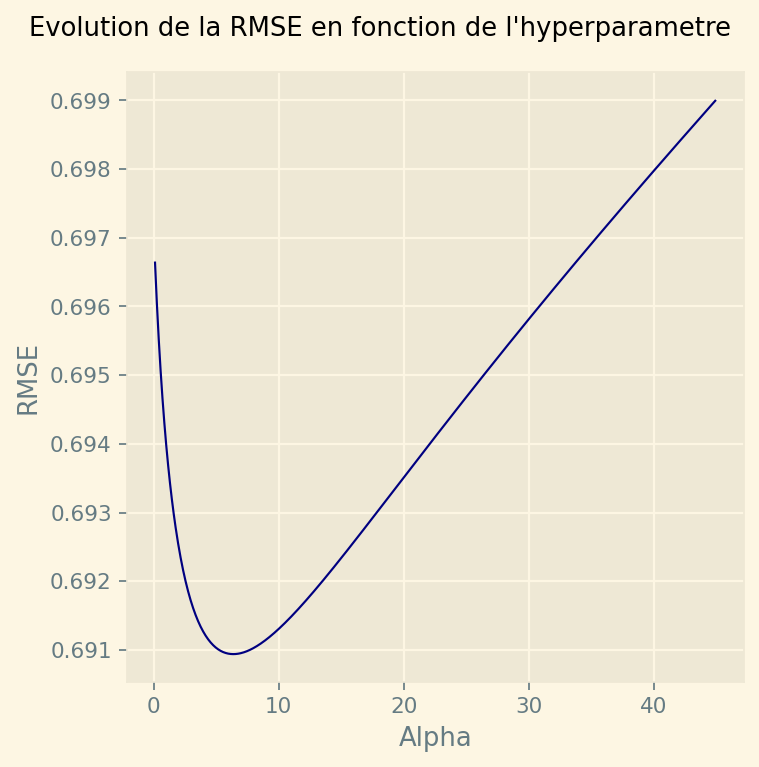

In [46]:
reg_candidate_one.ridge_plot()


In [47]:
reg_one_perf = reg_candidate_one.ridge_table


In [48]:
alphas_ridge = np.arange(1600, 2800, 0.1)  # different data different inputs via trial/error 
alphas_elnet = np.arange(42, 45, 1)  # We dont care about elnet, its the slowest and we wanna go fast
alphas_lasso = np.arange(1, 2, .5) # Same same

reg_candidate_two.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


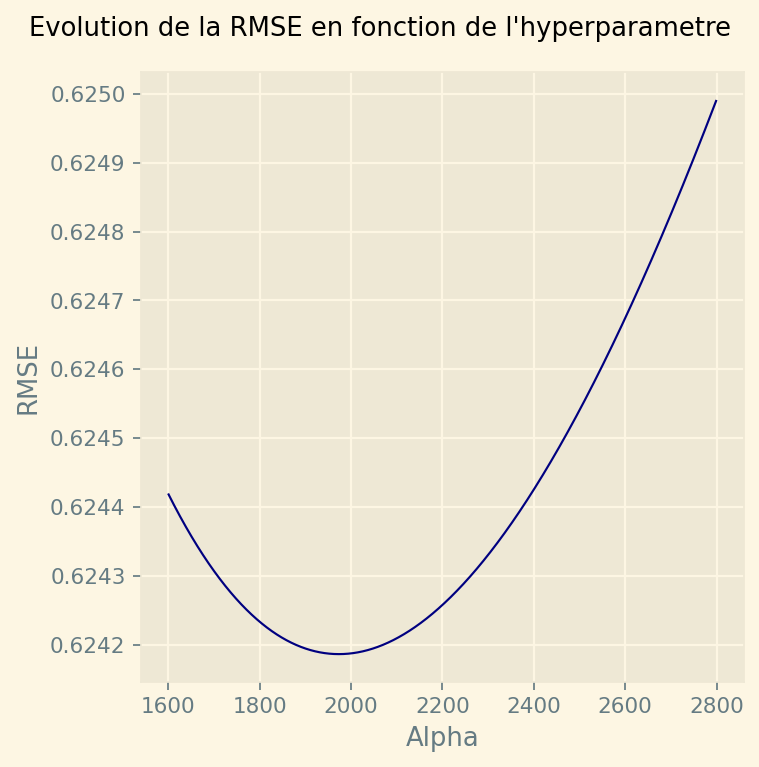

In [49]:
reg_candidate_two.ridge_plot()


In [50]:
reg_two_perf = reg_candidate_two.ridge_table


In [51]:
alphas_ridge = np.arange(5000, 6300, .1)  # different data different inputs via trial/error 
alphas_elnet = np.arange(42, 45, 1)  # We dont care about elnet, its the slowest and we wanna go fast
alphas_lasso = np.arange(1, 2, .5) # Same same

reg_candidate_three.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)


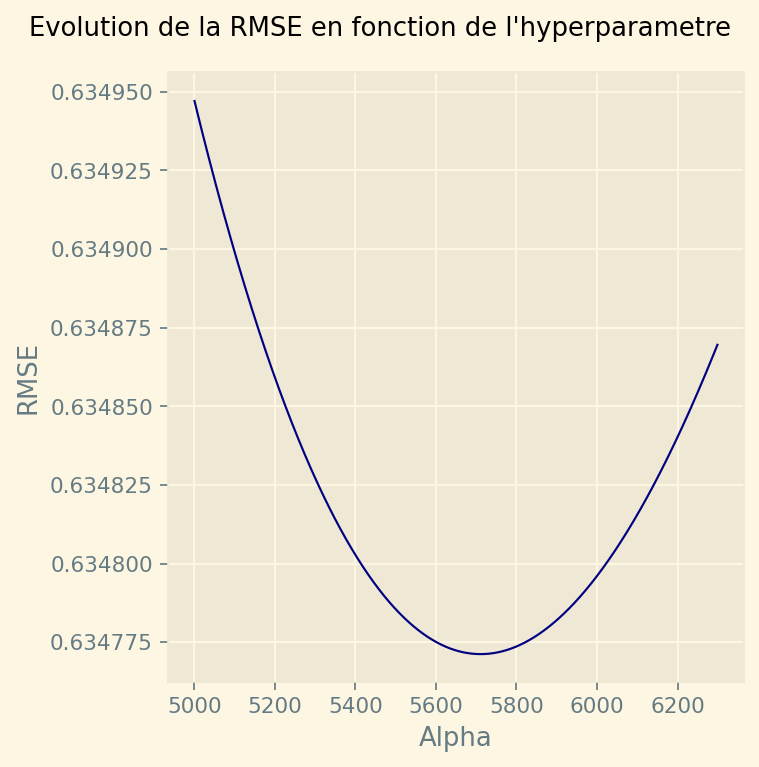

In [52]:
reg_candidate_three.ridge_plot()


In [53]:
reg_three_perf = reg_candidate_three.ridge_table


In [54]:
# COMPARING : 
print("Ridge perf, standard_scaled data :")
reg_one_perf


Ridge perf, standard_scaled data :


,RMSE,R2
Train,0.690939,0.612818
Test,0.689014,0.599228
Test/Train,0.997,0.978


In [55]:
print("Ridge perf, lowest skew, BCX included :")
reg_two_perf


Ridge perf, lowest skew, BCX included :


,RMSE,R2
Train,0.624186,0.625299
Test,0.733379,0.545956
Test/Train,1.175,0.873


In [56]:
print("Ridge perf, lowest skew, BCX excluded :")
reg_three_perf


Ridge perf, lowest skew, BCX excluded :


,RMSE,R2
Train,0.634771,0.608371
Test,0.730299,0.549762
Test/Train,1.15,0.904


# Conclusion & export : 

- A l'issue des benchmarks effectués sur les trois differentes methodes de transformation de variables, l'utilisation de la standardisation/mise à l'échelle des variables linéaires continues se montre la plus precise sur la regression Ridge (score R2 plus haut et RMSE plus faible que les deux autres "candidats"). C'est cette modification qui sera exportée pour une étude plus approfondie.

<hr>

# Résumé des modifications : 

- Standardisation et mise à l'echelle des données linéaires continues
- Creations de nouvelles variables : E* certified, BuildingAge
- Utilisation des proportions plutot que des tailles (building+parking)

<hr>

## Export des données pour analyses approfondies :

In [57]:
df_std_scaled.to_csv("./data/seattle_std_scaled.csv", sep=",")
